# Social Network Profile Analysis

El objetivo amplio de este trabajo es desarrollar un framework para extraer features sociodemográficos a partir de las imágenes de perfil de redes sociales. El experimento diseñado para comenzar a avanzar en esta dirección consiste en la construcción de un modelo de Machine Learning que permita clasificar imagénes de perfiles de Facebook entre dos grupos diferenciados. Para ello, hemos elegido dos grupos de Facebook existentes, de los cuales hemos descargado una muestra aleatoria de perfiles. Llamaremos "A" al grupo de nivel socioeconómico alto y "B" al grupo socioeconómico bajo. El ejericio propuesto tiene como finalidad entrenar un modelo que permita clasificar los perfiles según el grupo al que pertenecen. Comencemos!

## Extracción de features de las imágenes de los perfiles



In [1]:
from acc_func import glob_feat, get_labels, df_labels, completo_ds
import pandas as pd

A continuación generaremos features a partir de las imágenes de perfiles. Básicamente construiremos dos tipos de features. Por un lado se analizarán features globales, donde se analizarán aspectos como la distribución de los colores a través de la construcción de diversos histogramas y el análisis del contraste a través de la aplicación de filtros Laplacianos. Por otro lado, se construirán features a partir del reconocimiento de objetos y situaciones mediante la API de Computer Visión de Google Cloud. Para mayores detalles sobre el funcionamiento de estas funciones, recomendamos el análisis del código y documentación de las funciones auxiliares empleadas. 

In [4]:
"""
###estas funciones están comentadas para evitar su ejecución, ya que los datasets se hallan contruidos. De todos modos, brindamos el código para probar la construcción de nuevos sets de datos

###defino los path a las carpetas que contienen las imágenes que serán usadas para la construcción del dataset
path_ciu_ita='C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\imagenes\\Perfiles_Ciudadania_Italiana_Caba'
path_fio='C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\imagenes\\Perfiles_Merca_Libre_Villa_Fiorito'

###genero archivos con global features. Esta función genera y guarda los datasets con atributos globales en la ubicación introducida en el segundo parámetro de la función
glob_feat(path_ciu_ita, 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\ciu_glob.csv')
glob_feat(path_fio, 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\fio_glob.csv')

###bajo las labels de la API de Google. Esta función realizará las consultas en GCloud y guardará toda la información resultante en archivos .txt, que más adelante serán levantados por otra función para construir el dataset.
get_labels(path_ciu_ita,'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\labels\\ciu_lab', 'caba_lab')
get_labels(path_fio,'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\labels\\fio_lab', 'fio_lab')

###genero el dataset con labels. En base a la información descargada previamente, esta función genera un dataset y lo guarda en formato .csv
df_labels('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\labels\\ciu_lab', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\ciu_lab.csv')
df_labels('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\labels\\fio_lab', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\fio_lab.csv')

###mergeo los datasets de global feat y labels, guardo los datasets, genero target. Esta función mergea los datasets previos y guarda el dataset resultante en formato .csv. El primer parámetro de la función es la ubicación de un .txt que contiene la lista de las columnas de objetos y situaciones que queremos incluir en el dataset. 
completo_ds('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\cols_lab.txt', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\ciu_lab.csv', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\ciu_glob.csv', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\df_ciu.csv')
completo_ds('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\cols_lab.txt', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\fio_lab.csv', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\fio_glob.csv', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\df_fio.csv')
"""

## Análisis y selección de atributos

Para una primera selección de atributos, seguiremos dos criterios (sin perjuicio de refinar esta decisión en el futuro). En primer lugar, eliminaremos los atributos con una varianza muy elevada. Sobre este punto, debe tenerse en cuenta que por definición la varianza de los atributos será muy elevada en términos habituales...esto se debe a la naturaleza de nuestro objeto...En este primera aproximación eliminaremos todas las variables cuyo coeficiente de variación  sea superior a 10. Analizaremos por separado el set de imágenes de cada clase.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [3]:
###cargo los datasets a utilizar. 
ciu=pd.read_csv('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\df_ciu.csv', index_col=0)
fio=pd.read_csv('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\df_fio.csv', index_col=0)


In [4]:
###calculo las medias para cada grupo de imágenes
medias_ciu=ciu.iloc[:,:].mean(axis=0)
medias_fio=fio.iloc[:,:].mean(axis=0)

In [5]:
###calculo los SD
std_ciu=ciu.iloc[:,:].std(axis=0)
std_fio=fio.iloc[:,:].std(axis=0)

In [6]:
###calculo coef var
coef_var_ciu=std_ciu/medias_ciu
coef_var_fio=std_fio/medias_fio

coef_var_ciu=coef_var_ciu.sort_values()
coef_var_fio=coef_var_fio.sort_values()

Text(0.5, 0, 'Coeficiente de variación de los atributos del dataset de imágenes del grupo "A"')

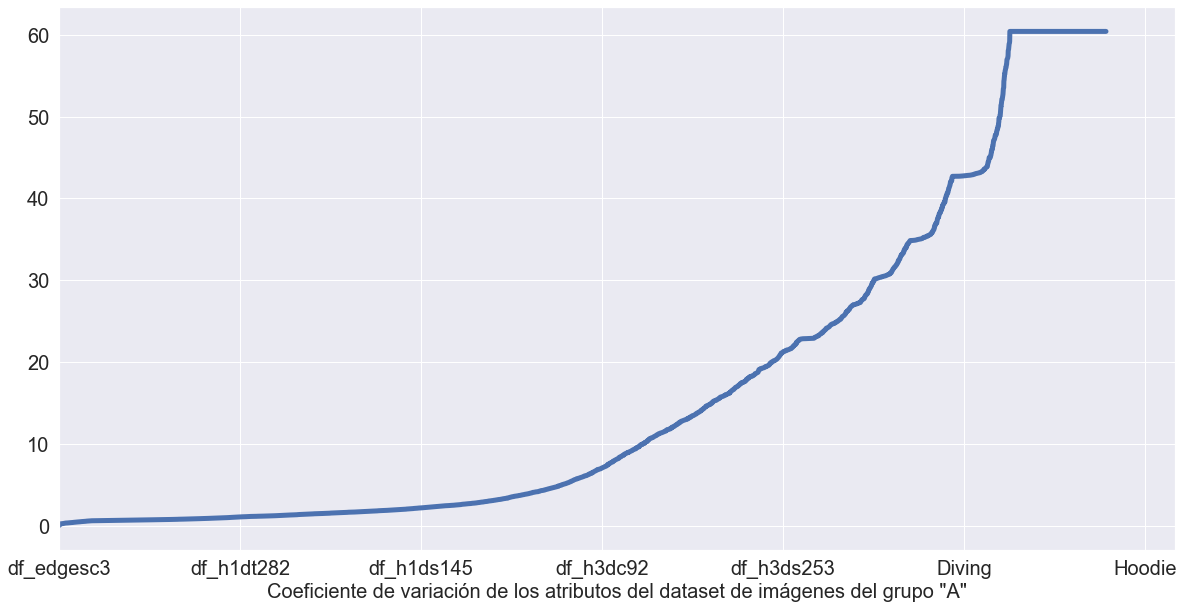

In [8]:
coef_var_ciu.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Coeficiente de variación de los atributos del dataset de imágenes del grupo "A"', fontsize=20)

Vemos que prácticamente la mitad de las variables tienen un CV menor a 10. A partir de 10 la curva se empina muy rápidamente. No queremos reducir demasiado el set de datos por ahora para no perder información que puede ser útil en el futuro. Veamos qué sucede con las imágenes del grupo "B".

Text(0.5, 0, 'Coeficiente de variación de los atributos del dataset de imágenes del grupo "B"')

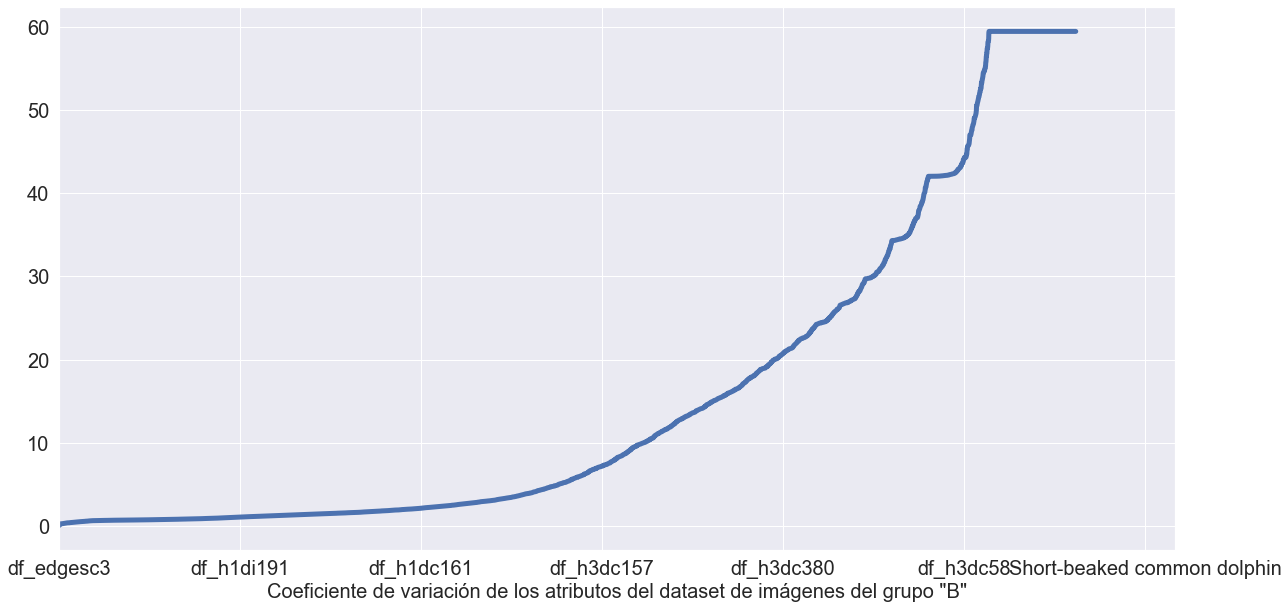

In [9]:
coef_var_fio.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Coeficiente de variación de los atributos del dataset de imágenes del grupo "B"', fontsize=20)

Vemos que se repite la distribución del grupo anterior. Vamos a quedarnos con los atributos que tengan un CV menor a 10 para cualquiera de los grupos.

In [10]:
###selecciono los atributos que me interesan
feat_ciu=set(coef_var_ciu.loc[coef_var_ciu<10].index)
feat_fio=set(coef_var_fio.loc[coef_var_fio<10].index)
feat=list(feat_ciu.union(feat_fio))

EL segundio criterio sobre el que seleccionaremos atributos será el ODD ratio entre los features para cada grupo. Es decir, buscaremos identificar aquellos atributos cuya presencia implique mayor (o menor) probabilidad de pertenencia a cada grupo. 

In [11]:
###calculo los ratios entre los features que fueron pre seleccionados
ratio=medias_ciu.loc[feat]/medias_fio.loc[feat]
ratio=ratio.sort_values(ascending=False)

Text(0.5, 0, 'Distribución de los ODD Ratio por feature')

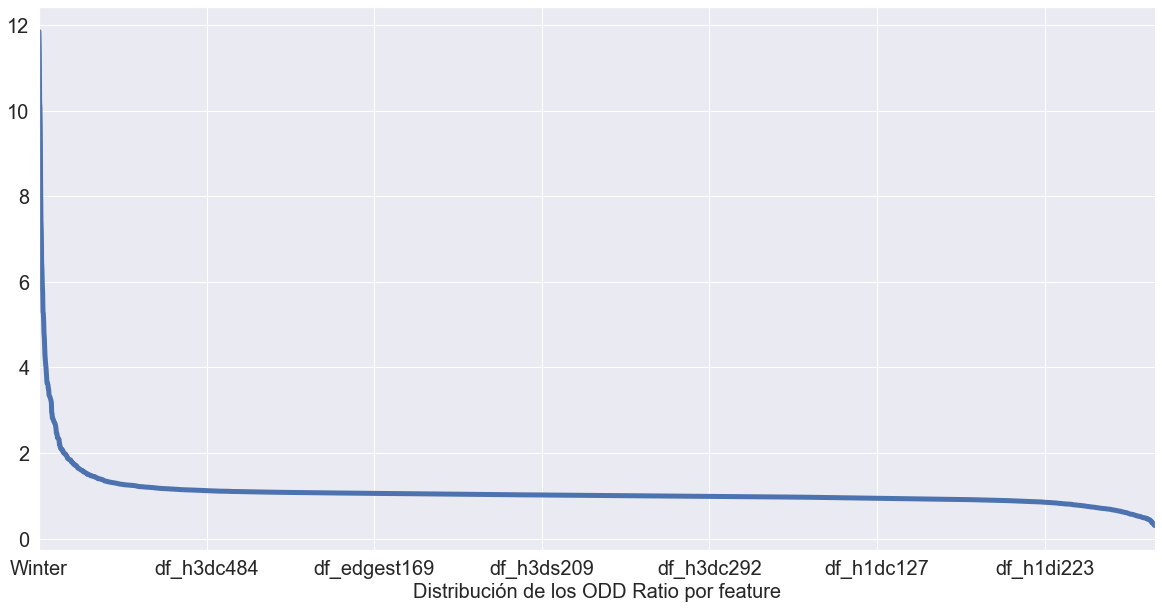

In [12]:
###Analizo visulamente la distribución de ODDS Ratio
ratio.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Distribución de los ODD Ratio por feature', fontsize=20)

Lo que se puede ver es que la mayor parte de los atributos no permiten diferenciar entre los grupos. Es decir, la probabilidad condicional de pertenecer a cada grupo, dado ese atributo, es similar a la probabilidad incondicional de hacerlo. Dicho de otro modo, la mayor parte de los atributos que pre seleccionamos presenta rasgos en común entre los Grupos "A" y "B". Aunque de aquí puede surgir otra línea de estudio, en función de las similitudes de los grupos, no es a lo que se apunta en este trabajo. 

Sin embargo, a pesar de que la mayor parte de los atributos no permite diferenciar los grupos, hay una minoría que sí. Seguiremos trabajando en base a ellos. En lo que sigue, seleccionaremos los atributos que tengan un ODD Ratio superior a 2 y menor a 0.5. 

In [13]:
ratio=ratio.loc[(ratio<0.5)|(ratio>2)]###me quedo con los features que impliquen un ODD ratio mayor a 2 para en cualquier dirección

feat_sel=list(ratio.index)###genero una lista para filtrar luego los datasets

In [14]:
###Visualizo los atributos seleccionados. ELimino de esta visualización los atributos globales, por la dificultad de su interpretación. Sólo visualizo los objetos y situaciones.
###Para facilitar la lectura se reexpresan los ODD Ratio valores menores a 1 en función del grupo contrario y se plotean en eje inverso (con signo negativo)

serie_viz=pd.Series(ratio)
serie_viz.loc[serie_viz<1]=-1/serie_viz.loc[serie_viz<1]
serie_viz_idx=[x for x in serie_viz.index if 'df_' not in x]###los atributos globales contienen el string df_
serie_viz=serie_viz.loc[serie_viz_idx]
serie_viz=serie_viz.sort_values(ascending=True)

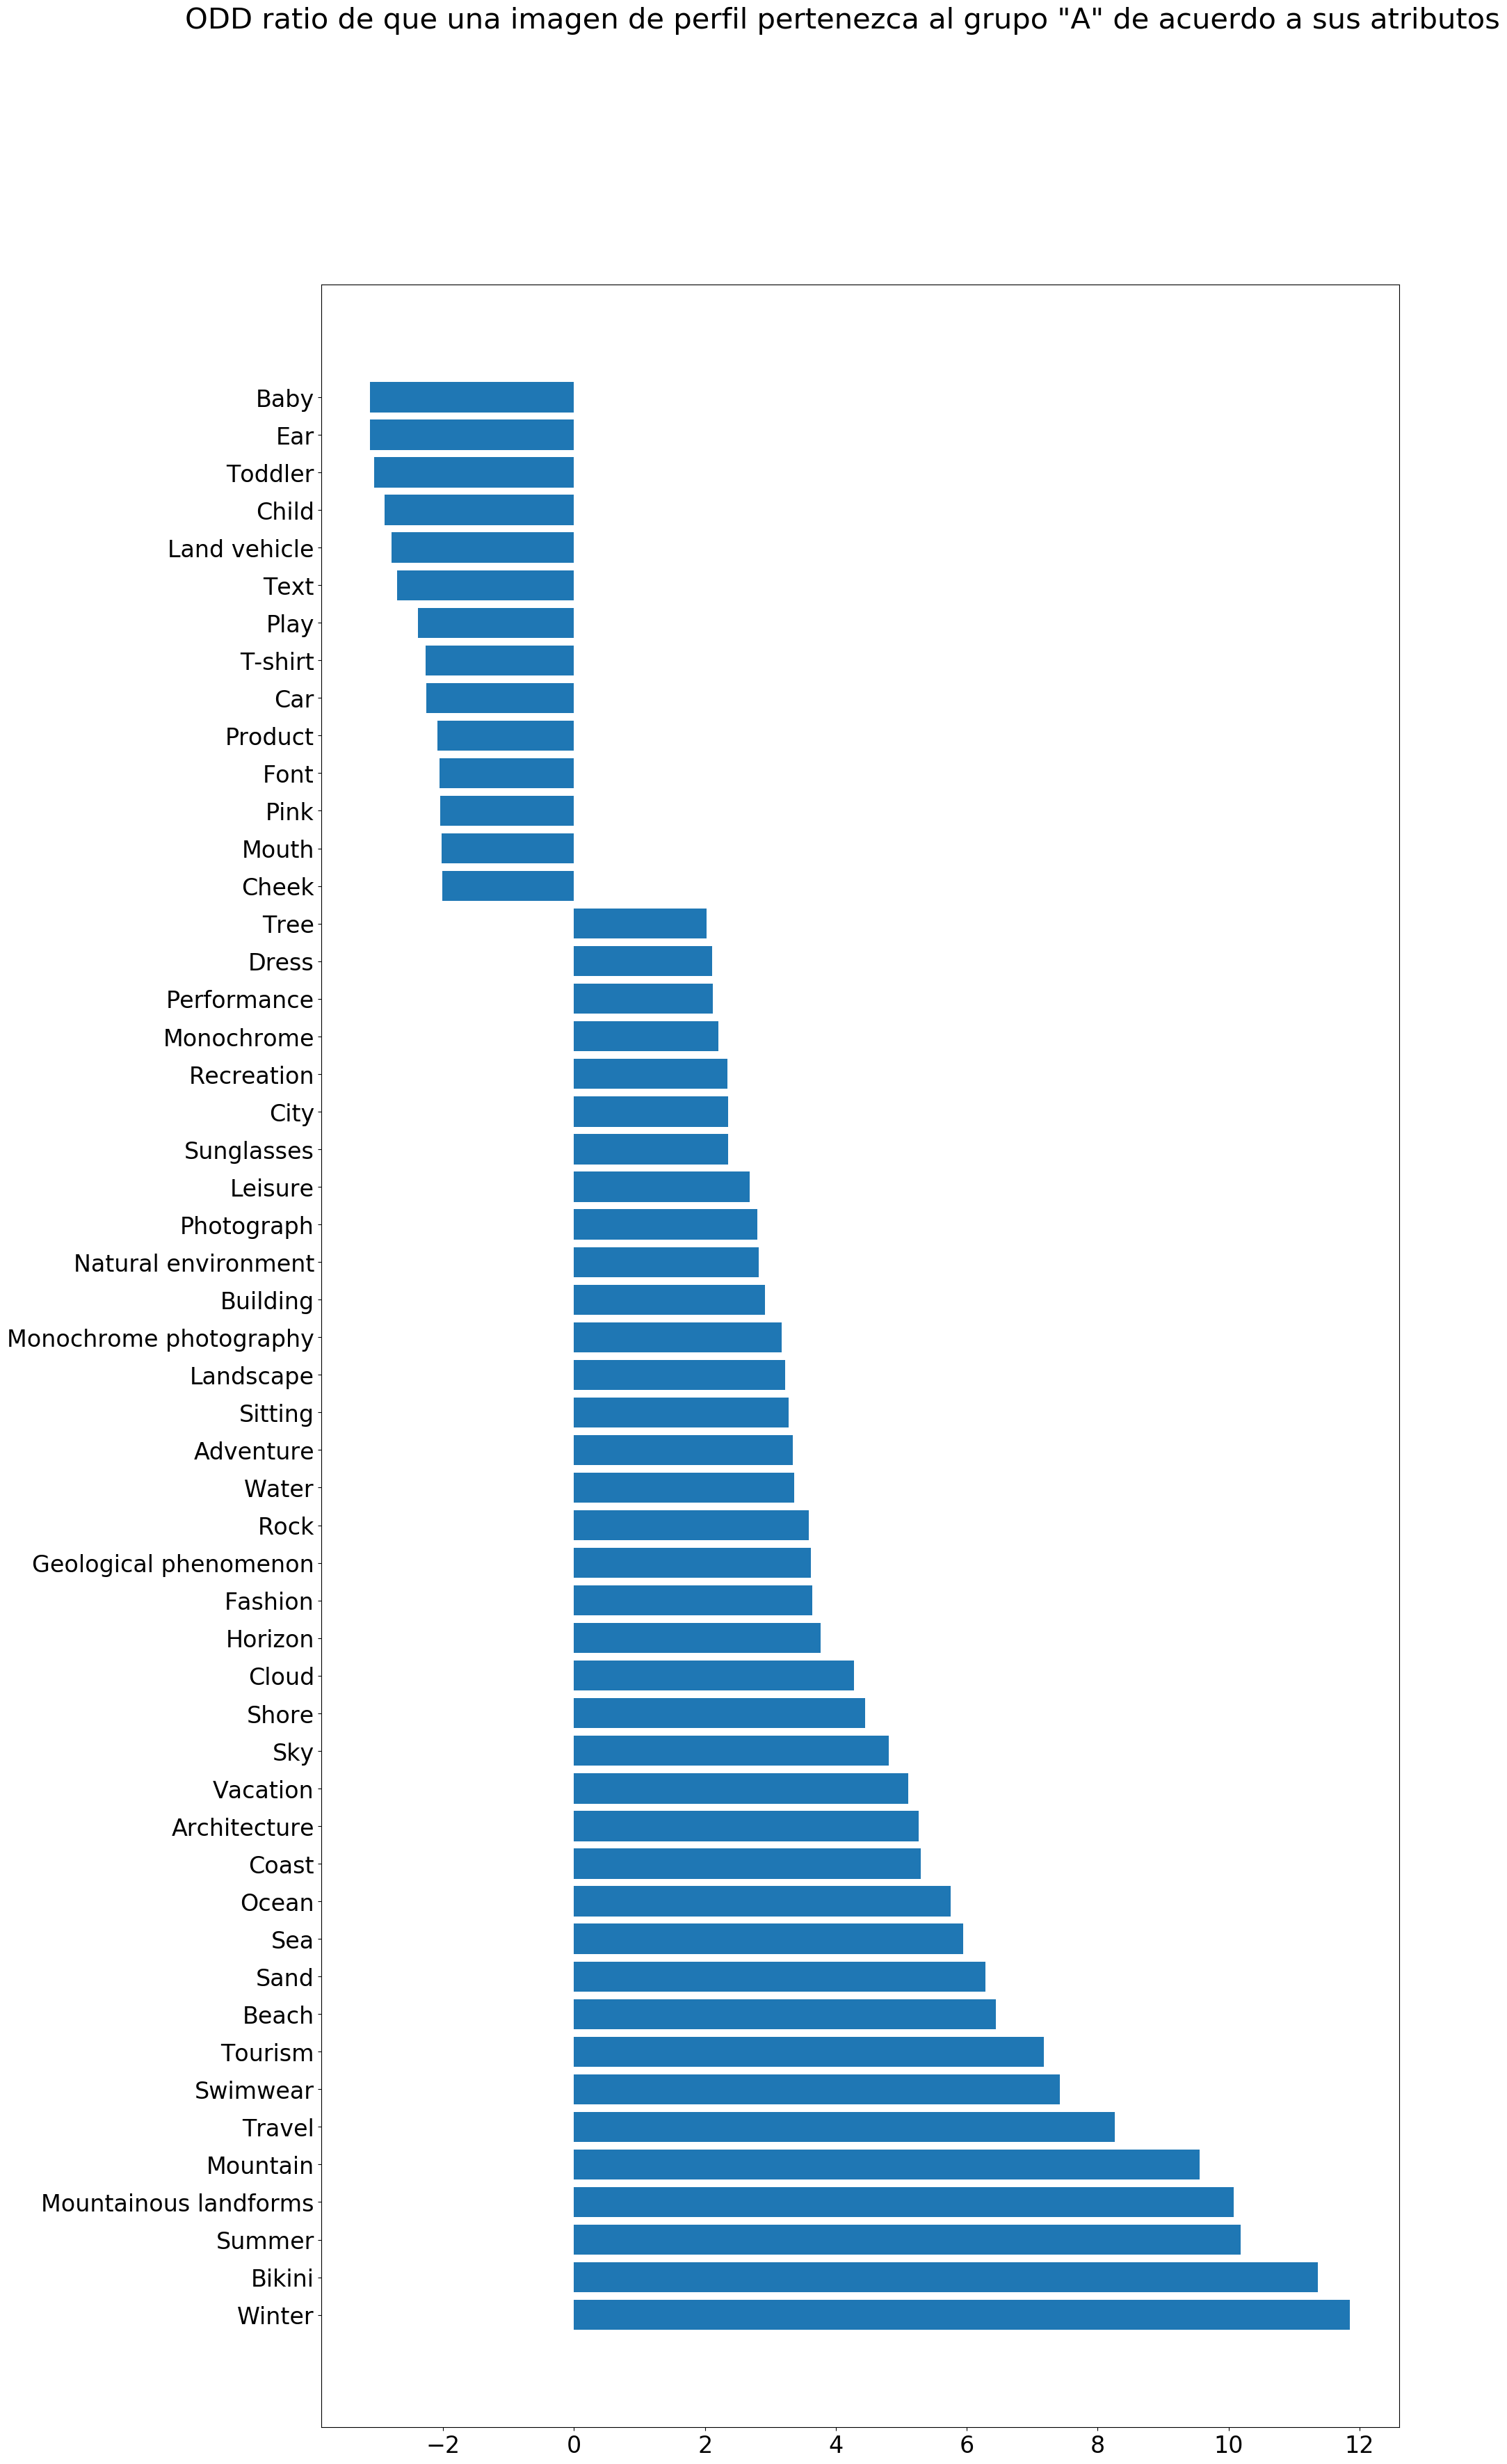

In [16]:
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(20, 40))

# Example data
atributos = [x for x in serie_viz.index]
y_pos = np.arange(len(atributos))

ax.barh(y_pos, pd.DataFrame(serie_viz).iloc[:,0],align='center')
ax.set_yticks(y_pos)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_yticklabels(atributos)
ax.invert_yaxis()  
fig.suptitle('ODD ratio de que una imagen de perfil pertenezca al grupo "A" de acuerdo a sus atributos', fontsize=30)

plt.show()

Imágenes "arquetípicas" del grupo A.  
   <table><tr>    
    <td> <img src="../imagenes/Perfiles_Ciudadania_Italiana_Caba/8360_10208639299997440_1579579214230527584_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Ciudadania_Italiana_Caba/13390_10152722879190683_1193453913958547517_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Ciudadania_Italiana_Caba/207377_1925657071391_7910254_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Ciudadania_Italiana_Caba/298784_103590236418805_823473134_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Ciudadania_Italiana_Caba/304298_109044392585301_1013561956_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Ciudadania_Italiana_Caba/1378570_10202138276763299_735989350_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    </tr></table>
    
Imágenes "arquetípicas" del grupo B.  
   <table><tr>
    <td> <img src="../imagenes/Perfiles_Merca_Libre_Villa_Fiorito/385824_2883797738025_2090648807_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Merca_Libre_Villa_Fiorito/150314_168225716532937_6741128_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Merca_Libre_Villa_Fiorito/553493_102315499929719_1138222288_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Merca_Libre_Villa_Fiorito/1377366_330387917107028_2109786850_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Merca_Libre_Villa_Fiorito/10394504_124063674598446_214650682492636912_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Merca_Libre_Villa_Fiorito/16602870_1778779815776306_4071524808217145632_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    </tr></table>
    
No obstante, también hay imágenes menos "arquetípicas", donde los features se presentan de forma casi aleatoria entre los grupos. Las imágenes que siguen fueron tomadas de los dos grupos.

   <table><tr>
    <td> <img src="../imagenes/Perfiles_Ciudadania_Italiana_Caba/1487318_10206178732567527_6701144053914347400_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Ciudadania_Italiana_Caba/17799347_10211712253217567_8920034104557390064_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Ciudadania_Italiana_Caba/375031_111943702346083_864552127_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Merca_Libre_Villa_Fiorito/993920_392812824158094_60868428_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Merca_Libre_Villa_Fiorito/13061976_1047124868659787_5735979009465037803_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    <td> <img src="../imagenes/Perfiles_Merca_Libre_Villa_Fiorito/47792740_750123458690426_9144454606951022592_n.jpg" alt="Drawing" style="width: 100px;"/> </td>
    </tr></table>

Se pueden extraer varias conclusiones iniciales de los datos anteriores. En primer lugar, los perfiles del grupo "A" (nivel socioeconómico alto), aparecen mucho más asociados a actividades vinculadas con las vacaciones, el descanso, la naturaleza y el aire libre. Imágenes donde aparecen las categorías "Winter", "Bikini", "Summer" y "Mountainous landforms" tienen una probabilidad de pretenecer al grupo "A" 10 veces superior a la de pertenecer al grupo "B". En cierto modo puede sospecharse que los individuos de este grupo eligen representarse a través de un estilo de vida específico, vinculado con los viajes, el deporte, el aire libre y la aventura. Por el contrario, las perfiles del grupo "B" tienden a exaltar valores familiares. Esto puede verse en las categorías "Baby", "Toddler" y "Child". La aparición de estas etiquetas implica una probabilidad 3 veces superior de que un perfil pertenezca al grupo "B" en lugar de al "A". Por otro lado, aparecen etiquetas llamativas, como las referidas a elementos faciales, "Mouth", "Ear", "Cheek", todas vinculadas al grupo "B". Una posible razón para ello es que estas imágenes tuviesen una mayor proporción de primeros planos. Es una alternativa a investigar. Probablemente vinculado con el plano de la imagen, podemos situar la categoría "T-Shirt". Las imágenes del grupo "B" se encuentran mucho más asociadas a esta categoría que las del grupo "A". Esto lleva a sospechar que se trata de imágenes de plano cercano, ya sea plano americano o  plano medio. De otro modo, es poco probable que se detecte la existencia de una remera en la imagen. Otro punto interesante a señalar es que las imágenes del grupo "B" se hallan mucho más asociadas a la categoría "Text" que las del grupo "A". Eso ha sido reconocido en un primer análisis exploratorio de los perfiles: en las imágenes del grupo "B" suelen encontrarse muchas veces leyendas y frases morales, de fé y de apoyo, así, las imágenes no sólo funcionan como una declaración implícita de valores, sino que lo hacen de forma explícita a través del texto. Por último dejamos apuntada la aparición de categorías como "Car" y "Land vehicle" asociadas al grupo "B". No tenemos bien claro de por qué se verifica esta situación, pero caben dos interpretaciones. En primer lugar, es de sospechar que algunas de estas etiquetas se vinculen con juguetes infantiles. Esto ha sido comprobado en la inspección visual de algunos perfiles. Además tiene sustento en el hecho de la aparición significativa de las etiquetas "Child" y "Play". No obstante, nos inclinamos a suponer que esto se debe en mayor medida a que los perfiles del grupo "B" incluyen mayores proporciones de imágenes con autos y motos que las del grupo "B". Habría que estudiar bien el significado semántico de estas imágenes, a priori esto demuestra o bien la falta de "cuidado" a la hora de componer una imagen (es decir, da lo mismo realizar una fotografía con un fondo de verde o en el garage de casa) o bien representa logros y valores materiales de los individuos (haber logrado comprarse el auto o la moto con sacrificio y esfuerzo).

In [155]:
###celda comentada para evitar su ejecución - los datasets ya se hallan consutruidos -
###guardo los datasets en base al recorte de features antes realizado
###guardo los nuevos datasets en base al recorte de features propuesto
###ciu.loc[:,feat_sel].to_csv('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\df_reducido_ciu.csv')
###fio.loc[:,feat_sel].to_csv('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\df_reducido_fio.csv')



In [17]:
###guardo la lista de atributos seleccionados para utilizar en el futuro
from sklearn.externals.joblib import dump, load
###dump(feat_sel, 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\feat_sel.bin', compress=True) Descomentar si se quiere volver a guardar la lista

C:\Users\lione\Anaconda3\envs\imagenes\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Construcción y análisis de modelos

In [18]:
###cargo los datasets ya reducidos en base a los atributos antes definidos.
ciu=pd.read_csv('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\df_reducido_ciu.csv', index_col=0)
fio=pd.read_csv('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\df_reducido_fio.csv', index_col=0)


In [19]:
###comenzaremos dividiendo el set de datos en train  y test. Luego aplicaremos técnicas de reducción de dimensionalidad
import random
prop_train=0.8

filas_ciu_train=random.sample(range(len(ciu)),round(len(ciu)*prop_train))
filas_fio_train=random.sample(range(len(fio)),round(len(fio)*prop_train))

filas_ciu_test=[x for x in range(0, len(ciu)) if x not in filas_ciu_train]
filas_fio_test=[x for x in range(0, len(fio)) if x not in filas_fio_train]

train=pd.concat([ciu.iloc[filas_ciu_train,:], fio.iloc[filas_fio_train,:]])    
test=pd.concat([ciu.iloc[filas_ciu_test,:], fio.iloc[filas_fio_test,:]])    

###genero lista  de target
y_train=[1]*len(filas_ciu_train)
y_train.extend([0]*len(filas_fio_train))

y_test=[1]*len(filas_ciu_test)
y_test.extend([0]*len(filas_fio_test))

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
###normalizo y aplico PCA para reducir dimensionalidad y evitar colinealidad entre variables (hay mucha!)
###No lo hemos analizado en profundiad a través de matrices de correlación, pero por la inspección de los datasets y el análisis
###De las salidas de los modelos, es evidente que existe una correlación importante entre los features. Por ejemplo, hay veces
###Que las labels "Child" y "Toddler" aparecen conjuntamente en una misma observación. Algo similar ocurre entre algunas labels
###y atributos globales. Es esperable que existe una correlación fuerte entre los features que contabilizan la aparición de pixels
###azules y las etiquetas "Sky", "Sea", etc. Como se dio por sentado la existencia de una colinealidad muy fuerte entre features
###la decisión inicial fue aplicar PCA para reducirla (y disminuir también el número de variables que ingresan al modelo).

scaler = StandardScaler()

###entreno el normalizado en base al datset de train
scaler.fit(train)

###transformo train y test en base al normalizado antes entrenado
X_train_norm = scaler.transform(train)
X_test_norm = scaler.transform(test)

pca = PCA(n_components=10)

###Ajusto PCA en base a train
pca.fit(X_train_norm)

###Aplico PCA a Train y Test
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

In [21]:
###Entreno un modelo básico
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn import metrics

classifier = RandomForestClassifier(n_estimators=200, max_depth= 4)  
classifier.fit(X_train_pca, y_train)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
###curva roc en test
y_pred = classifier.predict_proba(X_test_pca)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred[:,1])
metrics.auc(fpr, tpr)

0.7090577664468387

In [23]:
###La performance del modelo anterior no es muy satisfactoria...veamos la matriz de confusión...
###matriz de confusión
y_pred = classifier.predict(X_test_pca)  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred)) 

[[568 139]
 [347 382]]
              precision    recall  f1-score   support

           0       0.62      0.80      0.70       707
           1       0.73      0.52      0.61       729

    accuracy                           0.66      1436
   macro avg       0.68      0.66      0.66      1436
weighted avg       0.68      0.66      0.66      1436

0.6615598885793872


En líneas generales los resultados del modelo no son muy buenos. No obstante, diversos inputs en lo que refiere a selección de variables (y su tratamiento - normalización, PCA -) y diversos modelos y configuraciones de hiperparámetros no han redundado en resultados muy superiores. Entre todas las iteraciones en la construcción de los modelos, los mejores resultados han alcanzado un AUC de 0,73 promedio en Cross Validation, lo que tampoco es una gran mejora respecto a estos resultados. La matriz de confusión por otro lado puede mejorar un poco, pero tampoco vemos saltos cualitativos en este sentido. Nuestra lectura de estos resultados va en dos sentidos. A) Todavía queda información por extraer de las imágenes. No nos referimos tanto a trabajar sobre los atributos ya construidos, sino a refinar las estrategias de creación de atributos y análisis semántico de las mismas. Nueva información podría mejorar en algún modo los resultados. B) Nos estamos acercando al clasificador óptimo bayesiano. En base al análisis de los resultados de múltiples modelos y del conocimiento del dominio, juzgamos que es difícil seguir mejorando los modelos. Todo parece sugerir que las distribuciones en su existencia real siguen patrones no del todo claros, y con un gran nivel de ruido y solapamiento. Recordemos del análisis de atributos realizado más arriba que muy pocos eran portadores de información discriminante, y que por el contrario la mayoría evidenciaban no sólo una gran varianza, sino un importante solapamiento entre las clases. Esto no sólo se debe a posibles fallas en su construcción, sino a que realmente los grupos tienen mucho en común. En última instancia, estamos hablando de la vida social, donde por naturaleza los límites son permeables y fluidos...no existen en la sociedad grupos de contornos definidos y cerrados (salvo de casos muy limitados). Analizando visualmente las imágenes esto se hace palpable. Lo que sale a la superficie es que la pertenencia a un grupo social no determina férreamente el conjunto de los atributos socio/psicológicos del individuo...mucho menos su elección de foto de perfil de reder sociales...si bien condiciona y "propone", la elección última es del individuo. Y en eso hay mucho que a nuestros ojos aparece como azar. Parece un camino poco fructifero para seguir insistiendo. Pero podemos probar con otro! Qué tal si, en vez de analizar cada imagen de forma individual, como una única observación, las analizamos en contexto, como observaciones dentro de una muestra más amplia??? 

## De observaciones aisladas a imágenes en contexto

El paso conceptual de centrar el análisis en observaciones individuales a centrarlo en muestras de n cantidad de observaciones tiene ventajas y desventajas. Entre las desventajas, la principal es que se pierde la "potencia" individualizadora del modelo. Es decir, ya no podremos extraer información a título individual para cada una de las imágenes, ahora nos referiremos a muestras. Idealmente, el óptimo sería a partir de una imagen individual conocer (descubrir-predecir) todos los atributos sociodemográficos de nuestro interés. Esta información sería sumamente valiosa y accionable desde el punto de vista del negocio. No obstante, salvo que estemos dispuestos a aceptar demasiada varianza en nuestras predicciones - en línea o incluso mayores a las que arrojó el modelo antes presentado - esto no será posible. Por el contrario, la gran ventaja de trabajar con muestras de dos o más observaciones es que la varianza de sus predicciones irá en descenso a medida que aumentamos el n, mientras que lo contrario sucederá con la calidad de sus predicciones. Así, aunque no podremos extraer información a título individual de una imagen de perfil, sí podremos llegar a interesantes conclusiones sobre muestras con un nivel de certeza bastante elevado.

La lógica detrás de este planteo no sólo es una derivación del teorema central del límite - si bien nos beneficiamos de que al aumentar el n de la muestra la media de la misma tenderá a acercarse a la de la población original - sino de una particularidad de la vida social. Si pensamos a la sociedad como una estructura, veremos locus diversos que se repiten. En base a este concepto, podremos entender a la sociedad como una especie de cuadricula, donde existen espacios pre definidos (pero donde no está pre definido quién ocupará cada espacio...más allá de ciertos condicionantes psico sociales). Así, podremos hacer importantes supuestos para su estudio. De esta manera, podemos pensar a cada población como una cuadrícula con p proporción de individuos que tienen fotos de perfil en la playa, con p1 proporción de individuos con fotos de perfil haciendo deportes, y también con p2 proporción de individuos con fotos de perfil con su familia. De este modo, rompemos la linealidad, la rigidez que se buscaba en el modelo anterior, donde se buscaba implícitamente asociar cierta distribución de features con cada clase. El problema es que la realidad social no opera tan mecánicamente. Ahora buscaremos construir un modelo que entienda cómo se distribuyen estos mismos features pero en una muestra de cada uno de los grupos, tratando de entender como se expresa esta "cuadrícula" social en los perfiles de redes sociales.


 




A continuación desarrollaremos el modelo, no ya para clasificar observaciones individuales, sino muestras de n cantidad de observaciones. Para ello modificaremos el data set con el que veníamos trabajando. Ahora vamos a entrenar y evaluar sobre conjunto de muestras. Cada observación (línea) en los datasets que utilizaremos contiene la información sumarizada de una muestra de n elementos. Construiremos el set de datos del siguiente modo. Supongamos que vamos a trabajar con muestras de 5 observaciones. Lo que haremos será seleccionar 5 muestras (con reposición) del dataset original y calcular la media para cada uno de los atributos. Luego, repetiremos este procedimiento hasta construir la cantidad de observaciones que deseemos utilizar en el set de entrenamiento y validación. Nótese que esta técnica se asemeja bastante a bootstrapear el dataset original, solo que en lugar de trabajar sobre múltiples datasets, sumarizamos la información para construir una observación de lo que será el dataset final para entrenar el modelo. En este procedimiento se ha puesto especial cuidado en evitar cualquier data leakeage posible, realizando la partición entre train y test antes de comenzar el proceso de boostrapeado.

In [25]:
###Antes de comenzar a evaluar modelos con demasiada profundidad, buscaremos identificar cual es la cantidad de observaciones que
###permiten lograr una buena claseficación de la muestra. Para ello iteraremos sobre distintos n y evaluaremos los resultados.

###defino una función para iterar sobre muestras de distintos tamaños
###esta función toma como parámetro la cantidad de observaciones que compondrán la muestra. 
from acc_func import bootstrap_train_test
import numpy as np

def evalua_n_muestras(n):
    global ciu
    global fio ###se refiere a los datasets antes cargados
    train_ciu, test_ciu = bootstrap_train_test(n, 3500, 0.8, ciu) ###esta función realiza el muestreo con repetición y devuelve la información de los features sumarizada. Para mayores detalles sugerimos ver el script y documentación de las funciones accesorias
    train_fio, test_fio = bootstrap_train_test(n, 3500, 0.8, fio)

    train=pd.concat([train_ciu, train_fio])    
    test=pd.concat([test_ciu, test_fio])  

    ###genero lista de target
    y_train=[1]*len(train_ciu)
    y_train.extend([0]*len(train_fio))

    y_test=[1]*len(test_ciu)
    y_test.extend([0]*len(test_fio))

    ###normalizo el datset y aplico PCA
    scaler = StandardScaler()
    scaler.fit(train)

    X_train_norm = scaler.transform(train)
    X_test_norm = scaler.transform(test)

    pca = PCA(n_components=10)

    pca.fit(X_train_norm)

    X_train_pca = pca.transform(X_train_norm)
    X_test_pca = pca.transform(X_test_norm)

    ###entreno un modelo básico y analizo resultados
    classifier = RandomForestClassifier(n_estimators=200, max_depth= 4)  
    classifier.fit(X_train_pca, y_train)

    ###curva roc en test
    y_pred = classifier.predict_proba(X_test_pca)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred[:,1])
    
    return(metrics.auc(fpr, tpr))

roc=list()
for i in [1,2,3,4,5,10,20,50]:   
    roc.append(evalua_n_muestras(i))

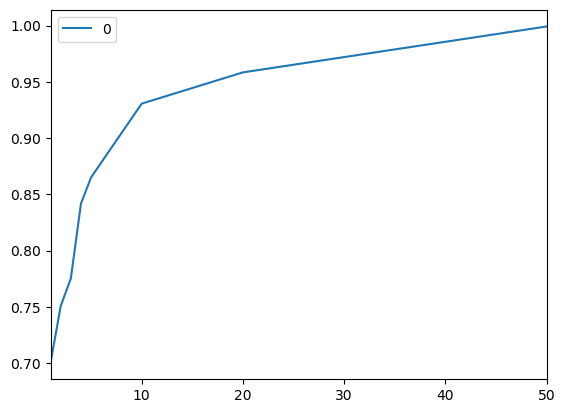

In [26]:
roc=pd.DataFrame(roc)
roc.index=[1,2,3,4,5,10,20,50]
roc.plot();

In [27]:
roc.columns=['Roc']
roc


,Roc
1,0.700460
2,0.750618
3,0.775208
4,0.841727
5,0.865081
10,0.930644
20,0.958440
50,0.999261


A través del gráfico y de la tabla podemos notar varias cosas. En un extremo, el entrenamiento del modelo con muestras de una observación tiene resultados poco satisfactorios, en línea con los anteriores. Es que, al margen del proceso de muestreo aleatorio, en esencia la naturaleza de los datos es la misma que la que fue utilizada previamente, y se basa en los features de un único caso. Pero, a medida que dotamos a estas observaciones de contexto, lo que equivale a aumentar el n de observaciones incluidas en la muestra, la performance del modelo aumenta marcadamente. En última instancia, para muestras grandes el modelo logra clasificarlas de forma casi perfecta. En lo que respecto al desarrollo de este modelo es todo un éxito!

A continuación lo que debemos evaluar es si el modelo que entrenamos aquí tiene capacidad para generalizar a otros conjuntos de imágenes, no sólo al conjunto de test. Lo que vamos a hacer es a evaluar si, aplicado a imágenes de otros grupos de Facebook,  el modelo entrenado resulta útil. Introduzcamos ahora los grupos "C" y "D". Por sus características sociodemográficas el grupo "C" tiene ciertos rasgos en común con el grupo "A", mientras que el grupo "D" tiene rasgos en común con el grupo "B". Idealmente, nuestro modelo sería útil si, al evaluar la nueva información, encuentra las muestras tomadas del grupo "C" con mayor probabilidad de pertenecer al grupo "A". Para el caso de las muestras tomadas del grupo "D", esperaríamos que el modelo estime una mayor probabilidad de pertenecer al grupo "B".

Previo a hacer este análisis se debe entrenar el modelo final con el que haré el análisis. En base a los resultados anteriores, juzgamos oportuno seguir trabajando con muestras de 50 observaciones.

In [28]:
###las líneas que siguen reprlican básicamente la función anterior, pero nos van a permitir guardar los modelos de normalización, PCA y RF
train_ciu, test_ciu = bootstrap_train_test(50, 3500, 0.8, ciu) ###esta función realiza el muestreo con repetición y devuelve la información de los features sumarizada. Para mayores detalles sugerimos ver el script y documentación de las funciones accesorias
train_fio, test_fio = bootstrap_train_test(50, 3500, 0.8, fio)

train=pd.concat([train_ciu, train_fio])    
test=pd.concat([test_ciu, test_fio])  

###genero lista de target
y_train=[1]*len(train_ciu)
y_train.extend([0]*len(train_fio))

y_test=[1]*len(test_ciu)
y_test.extend([0]*len(test_fio))

###normalizo el datset y aplico PCA
scaler = StandardScaler()
scaler.fit(train)

X_train_norm = scaler.transform(train)
X_test_norm = scaler.transform(test)

pca = PCA(n_components=10)

pca.fit(X_train_norm)

X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

###entreno un modelo básico y analizo resultados
classifier = RandomForestClassifier(n_estimators=200, max_depth= 4)  
classifier.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
###celdas comentadas para evitar guardar nuevamente los modelos!!!
###guardamos el Scaler, el PCA y el RF
###from sklearn.externals.joblib import dump, load
###dump(scaler, 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\std_scaler.bin', compress=True)
###dump(pca, 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\pca.bin', compress=True)
###dump(classifier, 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\rf.bin', compress=True)

## Evaluando el modelo sobre nuevos datos

In [30]:
###Antes de comenzar, debemos construir los sets de datos correspondientes a los Grupos "C" y "D". Lo dejo comentado ya que los datasets ya existen!!!
"""
###defino los path a las carpetas que contienen las imágenes que serán usadas para la construcción del dataset
path_utdt='C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\imagenes\\Perfiles_int_utdt'
path_carp='C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\imagenes\\Perfiles_Carpinteros'

###genero archivos con global features. Esta función genera y guarda los datasets con atributos globales en la ubicación introducida en el segundo parámetro de la función
glob_feat(path_utdt, 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\utdt_glob.csv')
glob_feat(path_carp, 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\carp_glob.csv')

###bajo las labels de la API de Google. Esta función realizará las consultas en GCloud y guardará toda la información resultante en archivos .txt, que más adelante serán levantados por otra función para construir el dataset.
get_labels(path_utdt,'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\labels\\utdt_lab', 'utdt_lab')
get_labels(path_carp,'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\labels\\carp_lab', 'carp_lab')

###genero el dataset con labels. En base a la información descargada previamente, esta función genera un dataset y lo guarda en formato .csv
df_labels('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\labels\\utdt_lab', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\utdt_lab.csv')
df_labels('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\labels\\carp_lab', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\carp_lab.csv')

###mergeo los datasets de global feat y labels, guardo los datasets, genero target. Esta función mergea los datasets previos y guarda el dataset resultante en formato .csv. El primer parámetro de la función es la ubicación de un .txt que contiene la lista de las columnas de objetos y situaciones que queremos incluir en el dataset. 
completo_ds('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\cols_lab.txt', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\utdt_lab.csv', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\utdt_glob.csv', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\df_utdt.csv')
completo_ds('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\cols_lab.txt', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\carp.csv', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\carp_glob.csv', 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\df_carp.csv')
"""


"\n###defino los path a las carpetas que contienen las imágenes que serán usadas para la construcción del dataset\npath_ds='C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\imagenes\\Perfiles_int_utdt'\npath_carp='C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\imagenes\\Perfiles_Carpinteros'\n\n###genero archivos con global features. Esta función genera y guarda los datasets con atributos globales en la ubicación introducida en el segundo parámetro de la función\nglob_feat(path_ds, 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\utdt_glob.csv')\nglob_feat(path_carp, 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\carp_glob.csv')\n\n###bajo las labels de la API de Google. Esta función realizará las consultas en GCloud y guardará toda la información resultante en archivos .txt, que más adelante serán levantados por otra función para construir el dataset.\nget_labels(path_ds,'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\utdt_lab', 'utdt_lab')\nget_labels(path_carp,'C:\\Users\\li

In [31]:
###Levanto todos los elementos necesarios para replicar el modelo construido (recorte de atributos, scaler, PCA y modelo)
from sklearn.externals.joblib import dump, load
scaler=load('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\std_scaler.bin')
pca=load('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\pca.bin')
classifier=load('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\rf.bin')
feat_sel=load('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\feat_sel.bin')

C:\Users\lione\Anaconda3\envs\imagenes\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\lione\Anaconda3\envs\imagenes\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator PCA from version 0.19.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\lione\Anaconda3\envs\imagenes\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\lione\Anaconda3\envs\imagenes\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.

In [33]:
###Levanto y proceso los nuevos datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from acc_func import bootstrap

utdt=pd.read_csv('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\df_utdt.csv', index_col=0)
carp=pd.read_csv('C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\datasets\\df_carp.csv', index_col=0)

utdt=utdt.loc[:,feat_sel]
carp=carp.loc[:,feat_sel]###selecciono los atributos utilizados anteriormente

utdt=bootstrap(150, 100, utdt)
carp=bootstrap(150, 100, carp)###bootstrapeo los datasets para simular las muestras. Generaremos 100 muestras de 150 observaciones.

utdt=scaler.transform(utdt)
carp=scaler.transform(carp)###normalizo los datasets

utdt=pca.transform(utdt)
carp=pca.transform(carp)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022C3EBCFBA8>]],
      dtype=object)

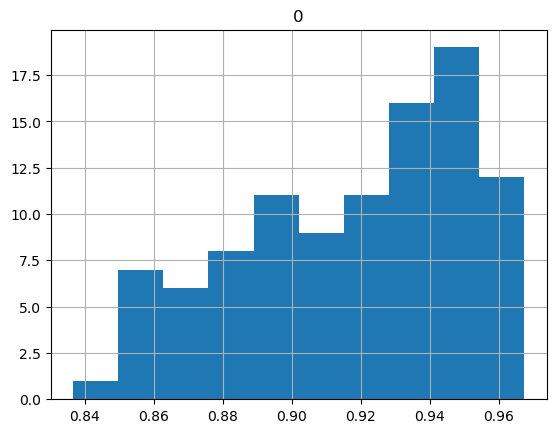

In [34]:
###Veamos que es lo que nos dice el modelo sobre las muestras obtenidas del el grupo "C". 
###Recordemos que este grupo tiene una marcada similitud con el grupo "A"
y_pred = classifier.predict_proba(utdt)
pd.DataFrame(y_pred[:,1]).hist()

El modelo otorgó elevadas probabilidades a las observaciones del grupo "C" de ser claseficadas como "A". Eso es exactamente lo que buscábamos! veamos ahora lo que sucede evaluando el grupo "D", que recordemos, tiene similitudes con el grupo "B".

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022C3E247E80>]],
      dtype=object)

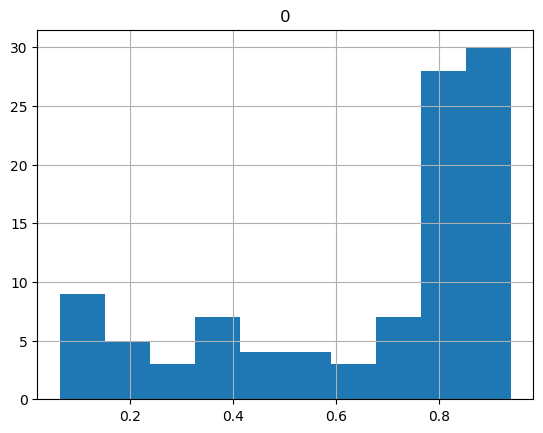

In [35]:
y_pred = classifier.predict_proba(carp)
pd.DataFrame(y_pred[:,1]).hist()

EL modelo no es satisfactorio en este caso. Si bien muchas muestras fueron clasificadas con mayor probabilidad de pertenecer a "B", la mayoría fueron clasificadas como "A". Es posible que el modelo utilizado, el Random Forest, haya aprendido detalles de la distribución del set de datos con que fue entrenado (lo que no necesariamente es sobreajuste, ya que en la evaluación sobre Test no tuvo problemas). La cuestión de fondo, es que el modelo parece haber aprendido regularidades pripias de los grupos con los que fue entrenado, pero que no pueden ser extrapoladas a otros grupos al margen de los que se utilizaron para entrenar el modelo. Lo que puede hacerse en este caso es utilizar un algoritmo con fronteras de decisión más rígidas...tal vez así podamos generalizar a otros grupos. Probemos con modelos lineales!!!

In [36]:
###Entreno una regresión lineal. En la salida no obtendré probabilidades, pero idealmente recibiré valores que fluctúen entre 0 y 1
###y en función de algún tipo de estimación, sea que se halle más cerca de uno u otro, estimaré una probabilidad de pertener a cada grupo (o medida de similitud).
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()

regr.fit(X_train_pca, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
###guardo el modelo de RL. Celda comentada para no guardar nuevamente el modelo!!!

###dump(regr, 'C:\\Users\\lione\\Dropbox\\Trabajo_perfiles\\reg_lin.bin', compress=True)

In [38]:
###Analizo el ajuste del modelo
y_pred=regr.predict(X_test_pca)
r2_score(y_test, y_pred) 

0.8848394344409904

Aunque no se puede comparar vis a vis el r2 con las métricas de evaluación empleadas anteriormente, todo parece apuntar a que el modelo tiene menor capacidad predictiva sobre el los datos de test. Pero, recordemos que esto era en cierta medida lo que buscábamos: un modelo más rígido, pero con mayor capacidad de generalizar sobre otro tipo de grupos. Veamos ahora que nos dice este modelo sobre los nuevos grupos "C" y "D".

In [39]:
###realizamos la predicción de los valores sobre los nuevos grupos
y_pred_C = regr.predict(utdt)
y_pred_D = regr.predict(carp)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022C3E7DF198>]],
      dtype=object)

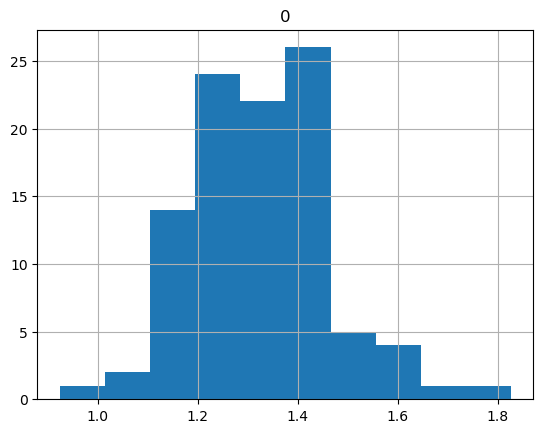

In [40]:
###Estás son las predicciones para el grupo C. Recordemos que este grupo tiene similitudes con el grupo A.
pd.DataFrame(y_pred_C).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022C3E4E6C88>]],
      dtype=object)

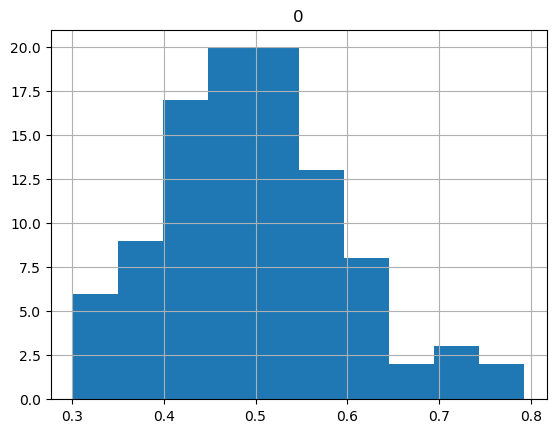

In [41]:
###Estás son las predicciones para el grupo D. Recordemos que este grupo tiene similitudes con el grupo B.
pd.DataFrame(y_pred_D).hist()

## Conclusiones

Lo que se desprende del análisis de los histogramas de las predicciones es que el modelo lineal tiene mejor capacidad para generalizar patrones que otros más sofisticados. Asimismo, podemos ver que todas las muestras han sido clasificadas como esperábamos que fuesen clasificadas. En los casos analizados, no existe superposión entre las predicciones para las muestras de ambos grupos. Las muestras del grupo "C" obtuvieron una predicción media de 1.32, con un valor mínimo de 0.92. Las muestras del grupo "D" en cambio obtuvieron una media de 0.49 y un máximo de 0.79. 

Crremos que con cierta refinación en los modelos estos resultados pueden seguir mejorando. No obstante, una mejoría importante de los modelos vendrá por el lado de un mejor etiquetado de los grupos - en este ejercicio asumimos correspondencia entre grupo de Facebook y características sociodemográficas. Si bien partimos del supuesto que los grupos con los que entrenamos representan un grupo social definido, la realidad es que existe mucho ruido en su composición. Aunque el ruido a nivel de la distribución de los perfiles dentro de un grupo socioeconómico es esperable, el hecho de tener ruido en el etiquetado introduce una complejidad adicional al trabajo. No todos los miembros del grupo "A" son de clase alta-media alta, y lo mismo vale para los miembros del grupo "B". Un etiquetado más preciso permitirá sin dudas mejores resultados. Por último, en este ejercicio asumimos que las imágenes de los perfiles responden únicamente al nivel social de los grupos. No obstante, la realidad es mucho más compleja, y al menos, deberían tenerse en cuenta otras variables de primer orden, especialmente edad y género.  Estamos seguros que avanzando sobre estos puntos los modelos serán mucho más potentes y accionables. Así y todo, creemos que como primer acercamiento al problema la resolución planteada resulta muy satisfactoria y abre la puerta a nuevos desarrollos. Este ejericio ha logrado probar la validez de la hipótesis inicial: a) A partir de las imágenes de perfil pueden extraerse features con carga semántica, b) Las imágenes de perfil pueden ser clasificadas en base a estos features y c) Estas conclusiones pueden ser generalizadas a otros grupos al margen de los que se utilizaron en el entrenamiento de los modelos.